![](Images/Sentiment_Analysis.png)

# Twitter Sentiment Analysis
Author: Volha Puzikava
***

## Disclaimer
The described analyses fulfill educational purposes only. The hypothetical business case and the results of sentiment analysis should not be perceived as real customers' attitudes and served as a push for remedial actions, as they have not been approved by any professional media organization.
***

## Overview
Sentiment analysis, also referred to as opinion mining, is an approach that identifies the emotional tone behind a body of text and categorizes pieces of writing as positive, negative or neutral. 

Sentiment analysis is a popular way for organizations to determine and classify opinions about a product, service, or idea. With the help of sentiment analysis companies get a better understanding of how customers feel about their brand, gain insights that help to improve their products and services, make business more responsive to customer feedback, react quickly to negative sentiment and turn it around, monitor brand’s reputation in real-time, and keep customers happy by always putting their feelings first.

This project tends to analyze Twitter sentiment about Apple and Google products in order to better understand how people feel about them. 
***

## Business Problem
Tweeter Home Enterteinment Group asked to analyze Twitter sentiment about Apple and Google products in order to help businesses monitor their brands and understand customers needs. The main purpose of the analysis was to build an NLP model that could rate the sentiment of a Tweet based on its content and give insights to the companies how people feel about their products.
***

## Data Understanding
The data for the analysis was taken from CrowdFlower via data.world links. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neutral.

The data represented an imbalanced multiclass classification problem. Since the company wanted to learn how customers felt about certain products, both false positives and false negatives were of a cost in the analysis. In the case of a false positive, a positive Tweet would be identified as negative and the company would have to spend resources and time to analyze it. However, in the case of a false negative, the model would identify a negative Tweet as positive, and the company would miss the sentiment of interest and let negativity escalate. Since the class proportion in the analyzed dataset was skewed and both false negatives and false positives were balanced in importance, Fbeta-measure, or the harmonic mean of the precision and recall values, was chosen as an evaluation metric.

The Fbeta-measure is a measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta: 
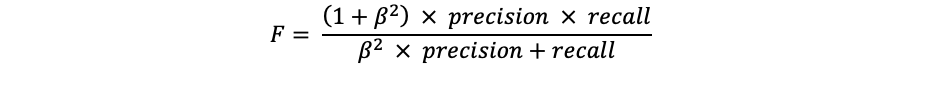

The β parameter is a strictly positive value that is used to describe the relative importance of recall to precision. A larger β value puts a higher emphasis on recall, while a smaller value puts a higher emphasis on precision. Three common values for the beta parameter are as follows:

* F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
* F1-Measure (beta=1.0): Balance the weight on precision and recall.
* F2-Measure (beta=2.0): Less weight on precision, more weight on recall

In our scenario, F1-measure was used. Since the data was imbalanced and the interest was in learning the feelings about the products, all classes were equally important. For evaluation, macro-F1 score was chosen. It was computed by taking the arithmetic mean of all the per-class F1 scores.
***

## Part I: Supervised ML Algorithms
## Data Preparation and Exploration
The data was uploaded and analyzed. Since the column containing product information the tweet was directed at, had about 64% of null values, it was excluded from the analysis. The columns with the text review and emotions were renamed to `'text'` and `'category'` respectively. The categories `'No emotion toward brand or product'` and `'I can't tell'` were treated as neutral emotions. The distribution of sentiments were plotted.

In [1]:
# Load the data
import pandas as pd

df = pd.read_csv('Data/tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [2]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# Check the percentage of null values
def nulls_summary_table(df):
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count', 'null_percentage']
    return null_values

nulls_summary_table(df)

,null_count,null_percentage
tweet_text,1,0.000110
emotion_in_tweet_is_directed_at,5802,0.638073
is_there_an_emotion_directed_at_a_brand_or_product,0,0.000000


In [4]:
# Check the distribution of Tweets' sentiments
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
# Rename the columns' titles
data = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
data = data.rename(columns = {'tweet_text' : 'text',\
                              'is_there_an_emotion_directed_at_a_brand_or_product' : 'category'})
# Remove null values
data.dropna(inplace=True)
data.head()

,text,category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [6]:
# Remove apostrophes to rename the categories
data['category'] = data['category'].replace("[',]", "", regex=True)
data['category'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I cant tell                            156
Name: category, dtype: int64

In [7]:
# Rename categories 'No emotion toward brand or product' and 'I cant tell' to 'Neutral emotion'
data['category'].replace('No emotion toward brand or product', 'Neutral emotion', inplace=True)
data['category'].replace('I cant tell', 'Neutral emotion', inplace=True)
data['category'].value_counts()

Neutral emotion     5544
Positive emotion    2978
Negative emotion     570
Name: category, dtype: int64

In [8]:
data.to_csv('Data/Data.csv', index=False)

In [9]:
# Check for class imbalance
print("Raw Counts:")
print(data['category'].value_counts())
print()
print('Percentages:')
print(data['category'].value_counts(normalize=True))

Raw Counts:
Neutral emotion     5544
Positive emotion    2978
Negative emotion     570
Name: category, dtype: int64

Percentages:
Neutral emotion     0.609767
Positive emotion    0.327541
Negative emotion    0.062692
Name: category, dtype: float64


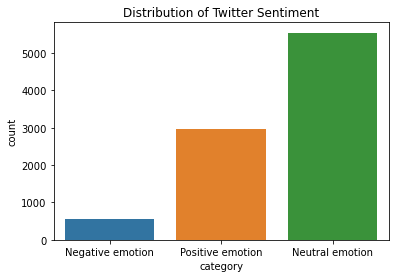

In [10]:
# Plot the distribution of values in column 'stroke'
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.countplot(data['category'])
plt.title('Distribution of Twitter Sentiment')
plt.savefig('Images/distribution_sentiment');

According to the plot, the majority of the Tweets (around 61%) were rated as neutral. 33% of Tweets in the dataset belonged to positive class, while only 6% were rated as negative. Mapping was used to transform categories of sentiments into numerical values, and a new column `'label'` was created.

In [11]:
# Transform categories into numerical variables using mapping
label = {
    'Neutral emotion' : 0,
    'Positive emotion' : 1,
    'Negative emotion' : 2
}
label_data = data['category'].map(label)

new_df = data.copy()
new_df['label'] = label_data
new_df.head()

,text,category,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1


In [12]:
# Check the type of each column
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      9092 non-null   object
 1   category  9092 non-null   object
 2   label     9092 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 604.1+ KB


A train-test split was performed. The prediction target for the analysis was the column `'label'`, so the data was separated into a train set and test set accordingly. 

In [13]:
# Split the outcome and predictors
X = new_df[['text', 'category']]
y = new_df['label']

In [14]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    4185
1    2215
2     419
Name: label, dtype: int64 

 0    1359
1     763
2     151
Name: label, dtype: int64


In [15]:
# Save training set as a dataframe
X_train = pd.DataFrame(X_train, columns = ['text', 'category'])
X_train.head()

,text,category
8605,Perfect attention to detail RT @mention Google...,Negative emotion
1303,my iphone was stolen and I got it back !!!!!! ...,Neutral emotion
8759,fuck I love Austin. Just left the Youtube Goog...,Positive emotion
5021,Spotted something rare a few minutes ago...a p...,Neutral emotion
3210,@mention fyi RT @mention I'll be at the Austi...,Neutral emotion


The first step of data cleaning in training set was standardizing case. The typical way to standardize case was to make everything lowercase. After making the case consistent, hashtags and @mentions were removed from the text. The text was then converted from a single long string into a set of tokens by using `RegexpTokenizer`. Stopwords were not removed as they contained useful information for the sentiment analysis (after stopwords removal, a negative review can become positive). The final step in the cleaning process was lemmatizing, that used part-of-speech tagging to determine how to transform a word.

In [16]:
# Transform training data to lowercase
X_train['text'] = X_train['text'].str.lower()
X_train.head()

,text,category
8605,perfect attention to detail rt @mention google...,Negative emotion
1303,my iphone was stolen and i got it back !!!!!! ...,Neutral emotion
8759,fuck i love austin. just left the youtube goog...,Positive emotion
5021,spotted something rare a few minutes ago...a p...,Neutral emotion
3210,@mention fyi rt @mention i'll be at the austi...,Neutral emotion


In [17]:
# Remove hashtags and @mention
X_train['text'] = X_train['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
X_train['text'] = X_train['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
X_train.head()

,text,category
8605,perfect attention to detail rt google recreat...,Negative emotion
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion
8759,fuck i love austin. just left the youtube goog...,Positive emotion
5021,spotted something rare a few minutes ago...a p...,Neutral emotion
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion


In [18]:
# Tokenize the data; create new column with tokenized data
import nltk
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
X_train['tokenized'] = X_train['text'].apply(tokenizer.tokenize)
X_train.head()

,text,category,tokenized
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,..."


In [19]:
# Download the collection of tags for classifying part-of-speech
import nltk
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to /Users/olga/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [20]:
# Tag the words from the text; create new column with tags
from nltk import pos_tag

X_train['tagged'] = X_train.tokenized.apply(pos_tag)
X_train.head()

,text,category,tokenized,tagged
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[(perfect, JJ), (attention, NN), (to, TO), (de..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[(my, PRP$), (iphone, NN), (was, VBD), (stolen..."
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[(fuck, VBN), (love, VB), (austin, NN), (just,..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[(spotted, VBN), (something, NN), (rare, JJ), ..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[(fyi, NN), (rt, NN), (ll, NN), (be, VB), (at,..."


In [21]:
# Transform the tags into the tags of our lemmatizers
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def tagged(token_list):
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in token_list]
    return doc_tagged

X_train['tagged'] = X_train['tagged'].apply(tagged)
X_train.head()

,text,category,tokenized,tagged
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[(perfect, a), (attention, n), (to, n), (detai..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[(my, n), (iphone, n), (was, v), (stolen, v), ..."
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[(fuck, v), (love, v), (austin, n), (just, r),..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[(spotted, v), (something, n), (rare, a), (few..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[(fyi, n), (rt, n), (ll, n), (be, v), (at, n),..."


In [22]:
# Lemmatize the text; create new column with lemmatized text
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(token[0], token[1]) for token in text]

X_train['lemmatized'] = X_train.tagged.apply(lemmatize_text)
X_train.head()

,text,category,tokenized,tagged,lemmatized
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[(perfect, a), (attention, n), (to, n), (detai...","[perfect, attention, to, detail, rt, google, r..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[(my, n), (iphone, n), (was, v), (stolen, v), ...","[my, iphone, be, steal, and, get, it, back]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[(fuck, v), (love, v), (austin, n), (just, r),...","[fuck, love, austin, just, leave, the, youtube..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[(spotted, v), (something, n), (rare, a), (few...","[spot, something, rare, few, minute, ago, phon..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[(fyi, n), (rt, n), (ll, n), (be, v), (at, n),...","[fyi, rt, ll, be, at, the, austin, convention,..."


Once the data was cleaned up (case standardized and tokenized), some exploratory data analysis was performed. Frequency distribution of top 10 tokens for each category was visualized with the help of a tool from NLTK called `FreqDist`. Better visualization of the words with the highest frequency within each category was achieved by using a word cloud, or tag cloud. 

To get the tokens out of the text, the TF-IDF algorithm ('Term Frequency-Inverse Document Frequency') was used. It didn't only count the term frequency within each document, but also included how rare the term was. Since the goal of the analysis was to distinguish the content of Tweets from others in corpus, TF-IDF was the most appropriate vectorizer.

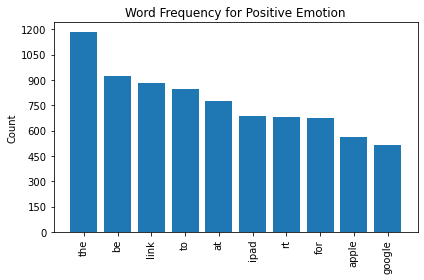

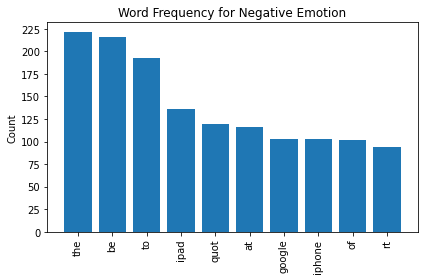

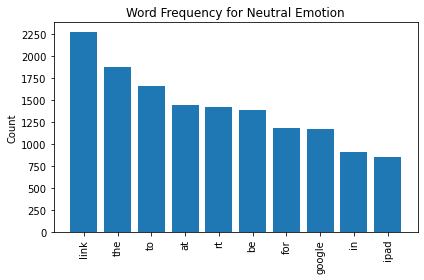

In [23]:
from nltk import FreqDist
from matplotlib.ticker import MaxNLocator

# Create a frequency distribution for each category in X_train
positive_freq = FreqDist(X_train[X_train['category']=='Positive emotion']['lemmatized'].explode())
negative_freq = FreqDist(X_train[X_train['category']=='Negative emotion']['lemmatized'].explode())
neutral_freq = FreqDist(X_train[X_train['category']=='Neutral emotion']['lemmatized'].explode())

def visualize_top_10(freq_dist, title):
    
    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    # Set up plot and plot data
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    ax.bar(tokens, counts)
    
    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='x', rotation=90)
    
# Plot the top 10 tokens for each category
visualize_top_10(positive_freq, "Word Frequency for Positive Emotion")
visualize_top_10(negative_freq, "Word Frequency for Negative Emotion")
visualize_top_10(neutral_freq, "Word Frequency for Neutral Emotion")

In [24]:
# Transform lemmatized tokens into lemmatized text; create new column
def lemmatized(text):
    return " ".join(text)

X_train['lemmatized_text'] = X_train.lemmatized.apply(lemmatized)
X_train.head()

,text,category,tokenized,tagged,lemmatized,lemmatized_text
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[(perfect, a), (attention, n), (to, n), (detai...","[perfect, attention, to, detail, rt, google, r...",perfect attention to detail rt google recreate...
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[(my, n), (iphone, n), (was, v), (stolen, v), ...","[my, iphone, be, steal, and, get, it, back]",my iphone be steal and get it back
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[(fuck, v), (love, v), (austin, n), (just, r),...","[fuck, love, austin, just, leave, the, youtube...",fuck love austin just leave the youtube google...
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[(spotted, v), (something, n), (rare, a), (few...","[spot, something, rare, few, minute, ago, phon...",spot something rare few minute ago phone not m...
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[(fyi, n), (rt, n), (ll, n), (be, v), (at, n),...","[fyi, rt, ll, be, at, the, austin, convention,...",fyi rt ll be at the austin convention center t...


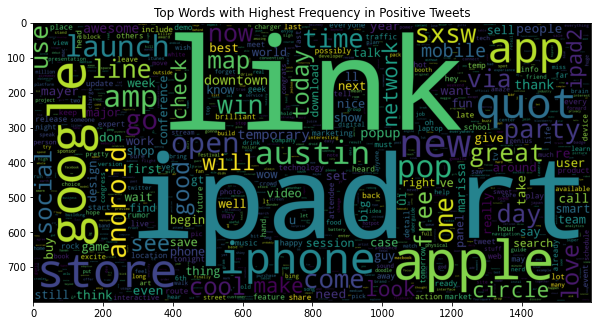

In [25]:
# Visualize the words with the highest frequency within positive category 
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Positive emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Positive Tweets')
plt.imshow(wc)
plt.savefig('Images/positive_sentiment');

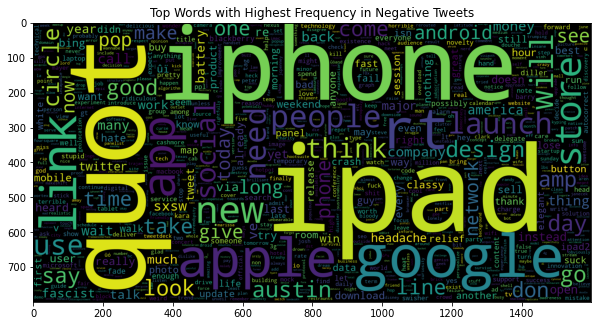

In [26]:
# Visualize the words with the highest frequency within negative category
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Negative emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Negative Tweets')
plt.imshow(wc)
plt.savefig('Images/negative_sentiment');

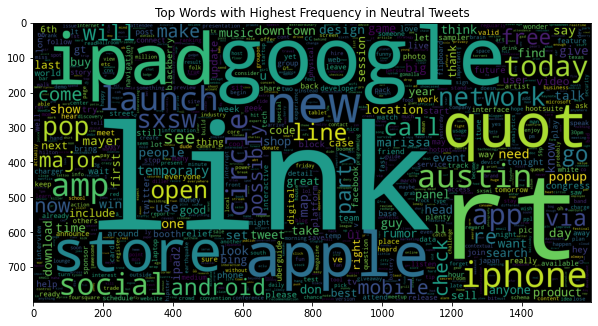

In [27]:
# Visualize the words with the highest frequency within neutral category
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Neutral emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Neutral Tweets')
plt.imshow(wc)
plt.savefig('Images/neutral_sentiment');

In [28]:
# Import the vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer on X_train['lemmatized_text'] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['lemmatized_text'])
df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())
df.head()

,00,000,00am,00pm,02,03,0310apple,06,10,100,...,ûïspecial,ûïthe,ûïwin,ûò,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the data was imbalanced, `SMOTE` (the Synthetic Minority Oversampling Technique) was used in order to improve the models' performance on the minority class. The technique oversampled negative and positive categories to have the same number of examples as the category with neutral sentiments.

In [29]:
# Use SMOTE class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Preview the synthetic sample class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)
print(y_train_resampled.value_counts())

2    4185
1    4185
0    4185
Name: label, dtype: int64


Before building the models, the preprocessing steps as stated above were applied to the test data, so the models performances could be evaluated on unseen data.

In [30]:
# Save test set as a dataframe
X_test = pd.DataFrame(X_test, columns = ['text', 'category'])

# Transform testing data to lowercase; remove hashtags and @mentions
X_test['text'] = X_test['text'].str.lower()
X_test['text'] = X_test['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
X_test['text'] = X_test['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)

# Tokenize the data
basic_token_pattern_test = r"(?u)\b\w\w+\b"
tokenizer_test = RegexpTokenizer(basic_token_pattern_test)
X_test['tokenized'] = X_test['text'].apply(tokenizer_test.tokenize)
X_test['tagged'] = X_test.tokenized.apply(pos_tag)
X_test['tagged'] = X_test['tagged'].apply(tagged)

# Lemmatize text
X_test['lemmatized'] = X_test.tagged.apply(lemmatize_text)
X_test['lemmatized_text_test'] = X_test.lemmatized.apply(lemmatized)
X_test.head()

,text,category,tokenized,tagged,lemmatized,lemmatized_text_test
7169,google close to launching new social network -...,Neutral emotion,"[google, close, to, launching, new, social, ne...","[(google, n), (close, r), (to, n), (launching,...","[google, close, to, launch, new, social, netwo...",google close to launch new social network circ...
2089,iphone charging at {link},Neutral emotion,"[iphone, charging, at, link]","[(iphone, n), (charging, v), (at, n), (link, n)]","[iphone, charge, at, link]",iphone charge at link
2303,"the walk by lady bird lake was lovely, but goo...",Negative emotion,"[the, walk, by, lady, bird, lake, was, lovely,...","[(the, n), (walk, n), (by, n), (lady, a), (bir...","[the, walk, by, lady, bird, lake, be, lovely, ...",the walk by lady bird lake be lovely but googl...
928,ûï not a rumor: apple doing popup store in do...,Positive emotion,"[ûï, not, rumor, apple, doing, popup, store, i...","[(ûï, n), (not, r), (rumor, v), (apple, n), (d...","[ûï, not, rumor, apple, do, popup, store, in, ...",ûï not rumor apple do popup store in downtown ...
5895,rt google to launch major new social network ...,Neutral emotion,"[rt, google, to, launch, major, new, social, n...","[(rt, n), (google, n), (to, n), (launch, v), (...","[rt, google, to, launch, major, new, social, n...",rt google to launch major new social network c...


In [31]:
# Fit the vectorizer on X_test['lemmatized_text_test'] and transform it
X_test_vectorized = tfidf.transform(X_test['lemmatized_text_test'])
df_test = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())

***

## Data Modeling
### Multinomial Naive Bayes Model
Multinomial Naive Bayes is one of the most popular supervised learning classifications that is used for the analysis of the categorical text data. The algorithm is based on the Bayes theorem and calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output.

In [32]:
# Import relevant class
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score 
    
# Instantiate a classifier
mnb = MultinomialNB()

# Evaluate the classifier on X_train_resampled and y_train_resampled
mnb_cv = cross_val_score(mnb,
                         X_train_resampled,
                         y_train_resampled)
mnb_cv

array([0.74591796, 0.7387495 , 0.74392672, 0.79649542, 0.78574273])

In [33]:
# Fit the model on the training set
mnb.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(mnb.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(mnb.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.8320191158900836
Accuracy of Test Set:
0.5666520017597888


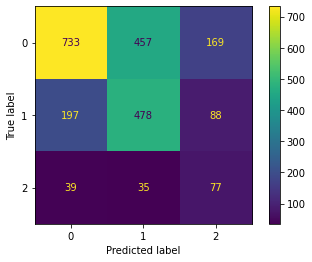

In [34]:
# Plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(mnb, X_test_vectorized, y_test);

Since the data was imbalanced and the company aimed to learn how people felt about the products, macro F1 score was calculated.

In [35]:
# Print classification report
from sklearn.metrics import classification_report
mnb_preds = mnb.predict(X_test_vectorized)

print('Classification Report of Multinomial Naive Bayes Model:')
print(classification_report(y_test, mnb_preds))

Classification Report of Multinomial Naive Bayes Model:
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      1359
           1       0.49      0.63      0.55       763
           2       0.23      0.51      0.32       151

    accuracy                           0.57      2273
   macro avg       0.49      0.56      0.50      2273
weighted avg       0.63      0.57      0.58      2273



In [36]:
# Calculate F score
from sklearn.metrics import f1_score

mnb_fscore = f1_score(y_test, mnb_preds, average='macro')
mnb_fscore

0.4996318020449346

Thus, the MultinomialNB model’s ability to both capture Tweets and be accurate with those Tweets was only 50%. The model also correctly identified Tweets as positive or negative about 57% of the time.

### Logistic Regression Model
The Logistic Regression class was configured for multinomial logistic regression by setting the `'multi_class'` argument to `'multinomial'` and the `'solver'` argument to a solver that supported multinomial logistic regression - `'lbfgs'`.

In [37]:
# Import relevant class
from sklearn.linear_model import LogisticRegression
    
# Instantiate a classifier
logreg = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')

# Evaluate the classifier on X_train_resampled and y_train_resampled
logreg_cv = cross_val_score(logreg,
                            X_train_resampled,
                            y_train_resampled)
logreg_cv

array([0.79649542, 0.79769016, 0.78693748, 0.85025886, 0.84547989])

In [38]:
# Fit the model on the training set
logreg.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(logreg.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(logreg.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.8817204301075269
Accuracy of Test Set:
0.6498020237571491


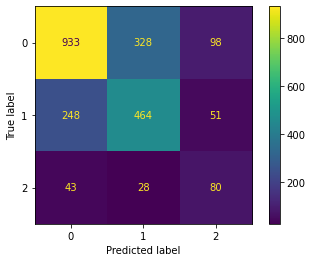

In [39]:
# Plot the confusion matrix
plot_confusion_matrix(logreg, X_test_vectorized, y_test);

In [40]:
# Print classification report
logreg_preds = logreg.predict(X_test_vectorized)

print('Classification Report of Logistic Regression Model:')
print(classification_report(y_test, logreg_preds))

Classification Report of Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1359
           1       0.57      0.61      0.59       763
           2       0.35      0.53      0.42       151

    accuracy                           0.65      2273
   macro avg       0.56      0.61      0.58      2273
weighted avg       0.67      0.65      0.66      2273



In [41]:
# Calculate F score
logreg_fscore = f1_score(y_test, logreg_preds, average='macro')
logreg_fscore

0.5765657022958405

The Logistic Regression model’s ability to both capture precision and recall got higher (58)%. The model also correctly identified a Tweet about 65% of the time. Thus, Logistic Regression performed a little better that MultinomialNB.

### Tuned Logistic Regression Model
The Logistic Regression model was tuned to check if it could perform any better.

In [42]:
# Import relevant class and function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Use the GridSerch to find better hyperparameters
logreg_tuned = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
param_grid = {'penalty' : ['l2', 'none'],
              'C' : range(0,2),
              'max_iter' : [50, 100, 150]}
    
grid_search = GridSearchCV(estimator = logreg_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': range(0, 2), 'max_iter': [50, 100, 150],
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [43]:
# Print the hyperparameters
grid_search.best_params_

{'C': 0, 'max_iter': 100, 'penalty': 'none'}

In [44]:
# Build a model with mentioned hyperparameters 
logreg_tuned = LogisticRegression(random_state=42,
                                  multi_class='multinomial',
                                  solver='lbfgs',
                                  C=0,
                                  max_iter=100,
                                  penalty='none')
logreg_tuned.fit(X_train_resampled, y_train_resampled)

print("Accuracy of Train Set:")
print(logreg_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(logreg_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9574671445639188
Accuracy of Test Set:
0.6392432908051033


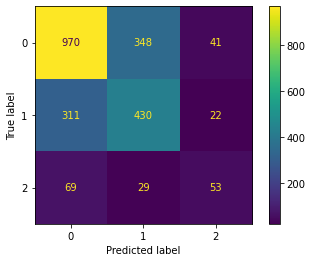

In [45]:
# Plot the confusion matrix
plot_confusion_matrix(logreg_tuned, X_test_vectorized, y_test);

In [46]:
# Print classification report
logreg_tuned_preds = logreg_tuned.predict(X_test_vectorized)

print('Classification Report of Logistic Regression Tuned Model:')
print(classification_report(y_test, logreg_tuned_preds))

Classification Report of Logistic Regression Tuned Model:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1359
           1       0.53      0.56      0.55       763
           2       0.46      0.35      0.40       151

    accuracy                           0.64      2273
   macro avg       0.57      0.54      0.55      2273
weighted avg       0.64      0.64      0.64      2273



In [47]:
# Calculate F score
logreg_tuned_fscore = f1_score(y_test, logreg_tuned_preds, average='macro')
logreg_tuned_fscore

0.5536352865870425

The Tuned Logistic Regression model performed worse than the baseline model. The abiliy to capture both precision and recall constituted only 55%, while the accuracy of the model decreased to 64%.

### K-Nearest Neighbors Model
KNN is a super simple algorithm, which assumes that similar things are in close proximity of each other. So if a datapoint is near to another datapoint, it assumes that they both belong to similar classes. 

In [48]:
# Import relevant class
from sklearn.neighbors import KNeighborsClassifier
    
# Instantiate a classifier
knn = KNeighborsClassifier()

# Evaluate the classifier on X_train_resampled and y_train_resampled
knn_cv = cross_val_score(knn,
                         X_train_resampled,
                         y_train_resampled)
knn_cv

array([0.75866189, 0.75388292, 0.75467941, 0.72998805, 0.84229391])

In [49]:
# Fit the model on the training set
knn.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(knn.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(knn.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9114297092791717
Accuracy of Test Set:
0.578090629124505


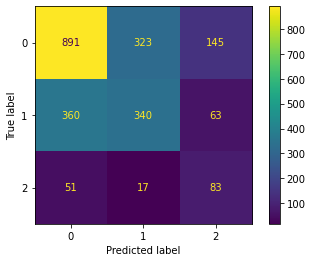

In [50]:
# Plot confusion matrix
plot_confusion_matrix(knn, X_test_vectorized, y_test);

In [51]:
# Print classification report
knn_preds = knn.predict(X_test_vectorized)

print('Classification Report of KNN Model:')
print(classification_report(y_test, knn_preds))

Classification Report of KNN Model:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1359
           1       0.50      0.45      0.47       763
           2       0.29      0.55      0.38       151

    accuracy                           0.58      2273
   macro avg       0.49      0.55      0.51      2273
weighted avg       0.60      0.58      0.58      2273



In [52]:
# Calculate F score
knn_fscore = f1_score(y_test, knn_preds, average='macro')
knn_fscore

0.5054930457808633

The results of the KNN model were not great. The F score constituted only 51%, meaning that the model could capture precision and recall only 51% of the time. The accuracy of the model was only 58%. The model was tuned to check if it could perform better.

### Tuned K-Nearest Neighbors Model

In [53]:
# Use the GridSerch to find better hyperparameters
knn_tuned = KNeighborsClassifier()
param_grid = {'n_neighbors' : [5, 10, 15, 20],
              'weights' : ['uniform', 'distance'],
              'metric' : ['manhattan', 'euclidean', 'minkowski']}
    
grid_search = GridSearchCV(estimator = knn_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean', 'minkowski'],
                         'n_neighbors': [5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [54]:
# Print the hyperparameters
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [55]:
# Build a model with mentioned hyperparameters 
knn_tuned = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
knn_tuned.fit(X_train_resampled, y_train_resampled)

print("Accuracy of Train Set:")
print(knn_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(knn_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9955396256471525
Accuracy of Test Set:
0.6405631324241091


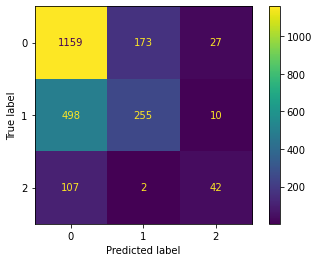

In [56]:
# Plot confusion matrix
plot_confusion_matrix(knn_tuned, X_test_vectorized, y_test);

In [57]:
# Print classification report
knn_tuned_preds = knn_tuned.predict(X_test_vectorized)

print('Classification Report of KNN Tuned Model:')
print(classification_report(y_test, knn_tuned_preds))

Classification Report of KNN Tuned Model:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      1359
           1       0.59      0.33      0.43       763
           2       0.53      0.28      0.37       151

    accuracy                           0.64      2273
   macro avg       0.59      0.49      0.51      2273
weighted avg       0.63      0.64      0.61      2273



In [58]:
# Calculate F score
knn_tuned_fscore = f1_score(y_test, knn_tuned_preds, average='macro')
knn_tuned_fscore

0.5116487116838537

The F score of the Tuned KNN model constituted 51%. The accuracy of the model was equal to 64%.

### Support Vector Machine Model
The multiclassification problem was broken down into multiple binary classification problems using `'one-to-one'` approach in SVC algorithm. The idea was to map data points to high dimensional space to gain mutual linear separation between every two classes, or in other words a binary classifier per each pair of classes.

In [59]:
# Import relevant class
from sklearn.svm import SVC
    
# Instantiate a classifier
svc = SVC(random_state=42, probability=True, decision_function_shape='ovo')

# Evaluate the classifier on X_train_resampled and y_train_resampled
svc_cv = cross_val_score(svc,
                         X_train_resampled,
                         y_train_resampled)
svc_cv

array([0.75746714, 0.80525687, 0.84070092, 0.9299084 , 0.93428913])

In [60]:
# Fit the model on the training set
svc.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(svc.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(svc.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9608124253285544
Accuracy of Test Set:
0.6832380114386274


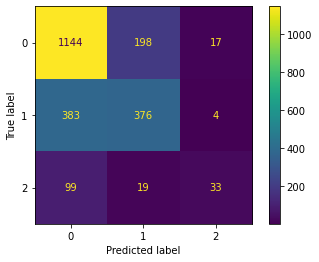

In [61]:
# plot confusion matrix
plot_confusion_matrix(svc, X_test_vectorized, y_test);

In [62]:
# Print classification report
svc_preds = svc.predict(X_test_vectorized)

print('Classification Report of SVC Model:')
print(classification_report(y_test, svc_preds))

Classification Report of SVC Model:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1359
           1       0.63      0.49      0.55       763
           2       0.61      0.22      0.32       151

    accuracy                           0.68      2273
   macro avg       0.65      0.52      0.55      2273
weighted avg       0.67      0.68      0.67      2273



In [63]:
# Calculate F score
svc_fscore = f1_score(y_test, svc_preds, average='macro')
svc_fscore

0.5476742177925625

Although the accuracy score of the SVM model was the highest (68%), the F score was equal to 55%. The model was tuned to check if it could perform any better. 

### Tuned Support Vector Machine Model

In [64]:
# Use the GridSerch to find better hyperparameters
svc_tuned = SVC(random_state=42, probability=True, decision_function_shape='ovo')
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 3, 'scale']}
    
grid_search = GridSearchCV(estimator = svc_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=SVC(decision_function_shape='ovo', probability=True,
                           random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 3, 'scale']},
             scoring='accuracy')

In [65]:
# Print the hyperparameters
grid_search.best_params_

{'C': 10, 'gamma': 3}

In [66]:
# Build a model with mentioned hyperparameters 
svc_tuned = SVC(random_state=42, probability=True, decision_function_shape='ovo', C=10, gamma=3)
svc_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(svc_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(svc_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9867781760254879
Accuracy of Test Set:
0.6489221293444787


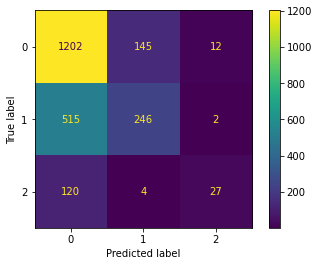

In [67]:
# Plot confusion matrix
plot_confusion_matrix(svc_tuned, X_test_vectorized, y_test);

In [68]:
# Print classification report
svc_tuned_preds = svc_tuned.predict(X_test_vectorized)

print('Classification Report of SVC Model:')
print(classification_report(y_test, svc_tuned_preds))

Classification Report of SVC Model:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      1359
           1       0.62      0.32      0.42       763
           2       0.66      0.18      0.28       151

    accuracy                           0.65      2273
   macro avg       0.65      0.46      0.49      2273
weighted avg       0.64      0.65      0.61      2273



In [69]:
# Calculate F score
svc_tuned_fscore = f1_score(y_test, svc_tuned_preds, average='macro')
svc_tuned_fscore

0.48610356803949667

The tuned SVM model performed even worse. Although the accuracy was 65%, the F score decreased to 49%.

### Random Forest Model
A random forest is an ensemble classifier that estimates based on the combination of different decision trees. Effectively, it fits a number of decision tree classifiers on various subsamples of the dataset. Also, each tree in the forest is built on a random best subset of features. Finally, the act of enabling these trees gives the best subset of features among all the random subsets of features. 

In [70]:
# Import relevant class
from sklearn.ensemble import RandomForestClassifier
    
# Instantiate a classifier
forest = RandomForestClassifier(random_state = 42)

# Evaluate the classifier on X_train_resampled and y_train_resampled
forest_cv = cross_val_score(forest,
                            X_train_resampled,
                            y_train_resampled)
forest_cv

array([0.76344086, 0.8172043 , 0.8339307 , 0.92074871, 0.9215452 ])

In [71]:
# Fit the model on the training set
forest.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(forest.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(forest.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9955396256471525
Accuracy of Test Set:
0.6797184337879455


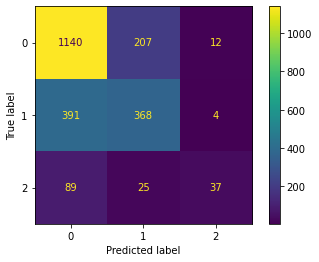

In [72]:
# Plot confusion matrix
plot_confusion_matrix(forest, X_test_vectorized, y_test);

In [73]:
# Print classification report
forest_preds = forest.predict(X_test_vectorized)

print('Classification Report of Random Forest Model:')
print(classification_report(y_test, forest_preds))

Classification Report of Random Forest Model:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1359
           1       0.61      0.48      0.54       763
           2       0.70      0.25      0.36       151

    accuracy                           0.68      2273
   macro avg       0.67      0.52      0.56      2273
weighted avg       0.67      0.68      0.66      2273



In [74]:
# Calculate F score
forest_fscore = f1_score(y_test, forest_preds, average='macro')
forest_fscore

0.5560293090141776

The F score of the Random Forest model was equal to 56%. The accuracy of the model constituted 68%. The model was tuned to check if it could perform any better.

### Tuned Random Forest Model

In [75]:
# Use the GridSerch to find better hyperparameters
forest_tuned = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators': [75, 100, 125, 150],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features' : ['sqrt', 'log2', 'none']}
    
grid_search = GridSearchCV(estimator = forest_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', 'none'],
                         'n_estimators': [75, 100, 125, 150]},
             scoring='accuracy')

In [76]:
# Print the hyperparameters
grid_search.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 150}

In [77]:
# Build a model with mentioned hyperparameters 
forest_tuned = RandomForestClassifier(random_state=42, n_estimators=150, criterion='gini', max_features='log2')
forest_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(forest_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(forest_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9955396256471525
Accuracy of Test Set:
0.6691597008358997


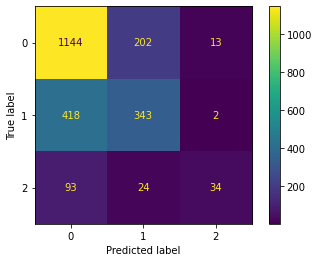

In [78]:
# Plot confusion matrix
plot_confusion_matrix(forest_tuned, X_test_vectorized, y_test);

In [79]:
# Print classification report
forest_tuned_preds = forest_tuned.predict(X_test_vectorized)

print('Classification Report of Random Forest Model:')
print(classification_report(y_test, forest_tuned_preds))

Classification Report of Random Forest Model:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1359
           1       0.60      0.45      0.52       763
           2       0.69      0.23      0.34       151

    accuracy                           0.67      2273
   macro avg       0.66      0.51      0.54      2273
weighted avg       0.66      0.67      0.65      2273



In [80]:
# Calculate F score
forest_tuned_fscore = f1_score(y_test, forest_tuned_preds, average='macro')
forest_tuned_fscore

0.5380463675354187

The F score of the tuned model was 54% as well, while the accuracy constituted 67%.

### XGBoost Model
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. When it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered to be best-in-class.

In [81]:
# Import relevant class
from xgboost import XGBClassifier

# Instantiate a MultinomialNB classifier
xgb = XGBClassifier(objective="multi:softprob", random_state=42)

# Evaluate the classifier on X_train_resampled and y_train_resampled
xgb_cv = cross_val_score(xgb,
                         X_train_resampled,
                         y_train_resampled)
xgb_cv

array([0.64874552, 0.76702509, 0.81441657, 0.89127838, 0.89446436])

In [82]:
# Fit the model on the training set
xgb.fit(X_train_resampled, y_train_resampled)

# Score on the training set
print("Accuracy of Train Set:")
print(xgb.score(X_train_resampled, y_train_resampled))

# Score on the test set
print("Accuracy of Test Set:")
print(xgb.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9166069295101553
Accuracy of Test Set:
0.6709194896612406


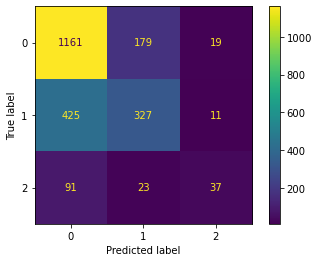

In [83]:
# Plot confusion matrix
plot_confusion_matrix(xgb, X_test_vectorized, y_test);

In [84]:
# Print classification report
xgb_preds = xgb.predict(X_test_vectorized)

print('Classification Report of XGBoost Model:')
print(classification_report(y_test, xgb_preds))

Classification Report of XGBoost Model:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1359
           1       0.62      0.43      0.51       763
           2       0.55      0.25      0.34       151

    accuracy                           0.67      2273
   macro avg       0.62      0.51      0.54      2273
weighted avg       0.66      0.67      0.65      2273



In [85]:
# Calculate F score
xgb_fscore = f1_score(y_test, xgb_preds, average='macro')
xgb_fscore

0.5368212087120506

The XGBoost model didn't perform very well. The accuracy of the model was 67%, while the f1 score constituted only 54%. The model was tuned to check if it performed any better.

### Tuned XGBoost Model

In [86]:
# Use the GridSerch to find better hyperparameters
xgb_tuned = XGBClassifier(objective="multi:softprob", random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2],
              'max_depth' : [4, 6],
              'min_child_weight' : [1, 2],
              'subsample' : [0.5, 0.7],
              'n_estimators' : [50, 100]}
    
grid_search = GridSearchCV(estimator = xgb_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [87]:
# Print the hyperparameters
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.7}

In [88]:
# Build a model with mentioned hyperparameters 
xgb_tuned = XGBClassifier(objective="multi:softprob", 
                          random_state=42,
                          learning_rate=0.2,
                          max_depth=6, 
                          min_child_weight=1,
                          n_estimators=100,
                          subsample=0.7)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

print("Accuracy of Train Set:")
print(xgb_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(xgb_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9010752688172043
Accuracy of Test Set:
0.6757589089309283


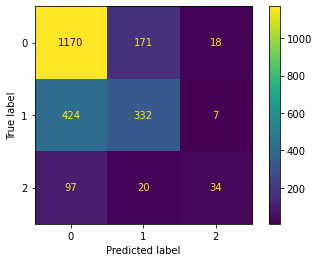

In [89]:
# Plot confusion matrix
plot_confusion_matrix(xgb_tuned, X_test_vectorized, y_test);

In [90]:
# Print classification report
xgb_tuned_preds = xgb_tuned.predict(X_test_vectorized)

print('Classification Report of Tuned XGBoost Model:')
print(classification_report(y_test, xgb_tuned_preds))

Classification Report of Tuned XGBoost Model:
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      1359
           1       0.63      0.44      0.52       763
           2       0.58      0.23      0.32       151

    accuracy                           0.68      2273
   macro avg       0.63      0.51      0.54      2273
weighted avg       0.67      0.68      0.65      2273



In [91]:
# Calculate F score
xgb_tuned_fscore = f1_score(y_test, xgb_tuned_preds, average='macro')
xgb_tuned_fscore

0.5357841143579103

The values of accuracy and f1 score of the tuned XGBoost Model stayed the same and were equal to 68% and 54% respectively.
***

### Model Evaluation
The graph with the F scores of different models was plotted. Since the company aimed to learn how people felt about the products, the model that produced a better F score was selected. It was found out that the best F score belonged to the Logistic Regression model. The classification report of the mentioned model and the F score were generated again.

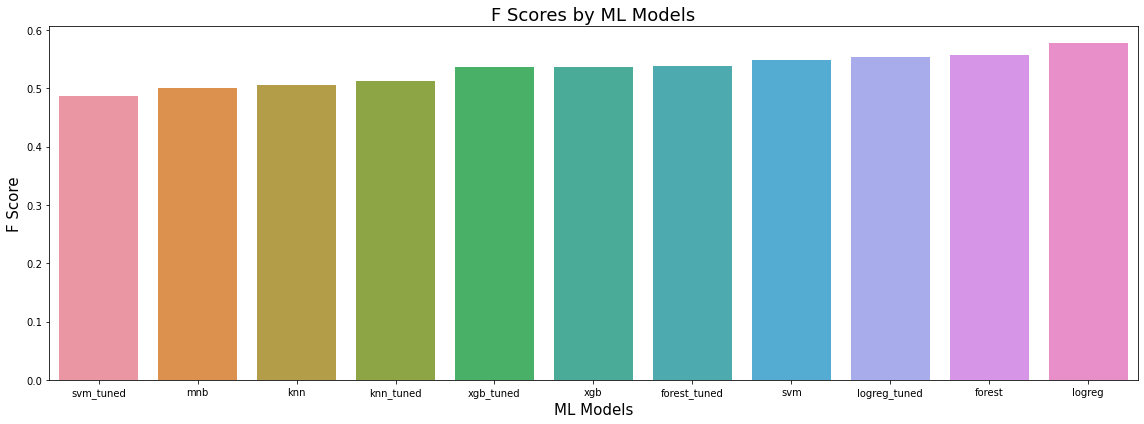

In [92]:
# Plot the graph with the best recall scores for different models
import numpy

fscore = [mnb_fscore, logreg_fscore, logreg_tuned_fscore, knn_fscore, knn_tuned_fscore,
          svc_fscore, svc_tuned_fscore, forest_fscore, forest_tuned_fscore, xgb_fscore, xgb_tuned_fscore]
models = ['mnb', 'logreg', 'logreg_tuned', 'knn', 'knn_tuned', 
          'svm', 'svm_tuned', 'forest', 'forest_tuned', 'xgb', 'xgb_tuned']
f_score = [round(num, 3) for num in fscore]

df_fscore = pd.DataFrame({'models': models, 'fscore': f_score}).sort_values(
    'fscore', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='fscore', data=df_fscore)
plt.xlabel("ML Models", size=15)
plt.ylabel("F Score", size=15)
plt.title("F Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("Images/fscore.png", dpi=100)

In [93]:
# Print classification report
logreg_preds = logreg.predict(X_test_vectorized)

print('Classification Report of Logistic Regression Model:')
print(classification_report(y_test, logreg_preds))

Classification Report of Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1359
           1       0.57      0.61      0.59       763
           2       0.35      0.53      0.42       151

    accuracy                           0.65      2273
   macro avg       0.56      0.61      0.58      2273
weighted avg       0.67      0.65      0.66      2273



In [94]:
# Calculate F score
logreg_fscore = f1_score(y_test, logreg_preds, average='macro')
logreg_fscore

0.5765657022958405

Based on the report, it was determined that the model correctly identifies a Tweet about 65% of the time. The F score value for the model is 58%, meaning that the model's balanced ability to both capture Tweets (recall) and be accurate with those Tweets (precision) is only 57%. The results were not perfect and neural networks were tried out.